# Risk Metrics Suite for Tail Risk Analysis

This notebook demonstrates the comprehensive risk metrics suite for quantifying tail risk in manufacturing insurance applications.

In [1]:
# Standard imports
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Import our modules
from ergodic_insurance.src.risk_metrics import RiskMetrics, compare_risk_metrics
from ergodic_insurance.src.loss_distributions import (
    LognormalLoss, ParetoLoss, ManufacturingLossGenerator
)

print("Modules loaded successfully")

Modules loaded successfully


## 1. Generate Manufacturing Loss Scenarios

First, let's generate realistic loss scenarios for a manufacturing company.

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate losses using ManufacturingLossGenerator
# Configure the parameters for each loss type
attritional_params = {
    'base_frequency': 5.0,
    'severity_mean': 50_000,
    'severity_cv': 0.8,
    'revenue_scaling_exponent': 0.3,
    'reference_revenue': 50_000_000
}

large_params = {
    'base_frequency': 0.5,
    'severity_mean': 2_000_000,
    'severity_cv': 1.2,
    'revenue_scaling_exponent': 0.2,
    'reference_revenue': 50_000_000
}

catastrophic_params = {
    'base_frequency': 0.02,
    'severity_xm': 10_000_000,
    'severity_alpha': 2.5
}

generator = ManufacturingLossGenerator(
    attritional_params=attritional_params,
    large_params=large_params,
    catastrophic_params=catastrophic_params,
    seed=42
)

# Simulate 10,000 annual loss scenarios
n_simulations = 10000
annual_revenue = 50_000_000
annual_losses = []

for _ in range(n_simulations):
    # Generate losses for one year with the given revenue
    events, stats = generator.generate_losses(duration=1.0, revenue=annual_revenue)
    total_loss = sum(event.amount for event in events)
    annual_losses.append(total_loss)

annual_losses = np.array(annual_losses)

print(f"Generated {n_simulations:,} annual loss scenarios")
print(f"Mean annual loss: ${np.mean(annual_losses):,.0f}")
print(f"Median annual loss: ${np.median(annual_losses):,.0f}")
print(f"Max annual loss: ${np.max(annual_losses):,.0f}")

Generated 10,000 annual loss scenarios
Mean annual loss: $1,602,519
Median annual loss: $380,042
Max annual loss: $238,069,047


## 2. Calculate Core Risk Metrics

Now let's calculate the key risk metrics: VaR, TVaR, PML, and Expected Shortfall.

In [3]:
# Initialize risk metrics calculator
metrics = RiskMetrics(annual_losses, seed=42)

# Calculate VaR at different confidence levels
confidence_levels = [0.90, 0.95, 0.99, 0.995, 0.999]
var_results = {}
tvar_results = {}

print("Value at Risk (VaR) and Tail VaR (TVaR)\n" + "="*50)
print(f"{'Confidence':<12} {'VaR':>15} {'TVaR':>15} {'TVaR/VaR':>10}")
print("-"*52)

for conf in confidence_levels:
    var_val = metrics.var(conf)
    tvar_val = metrics.tvar(conf)
    var_results[conf] = var_val
    tvar_results[conf] = tvar_val
    
    print(f"{conf:>10.1%}  ${var_val:>14,.0f}  ${tvar_val:>14,.0f}  {tvar_val/var_val:>9.2f}")

Value at Risk (VaR) and Tail VaR (TVaR)
Confidence               VaR            TVaR   TVaR/VaR
----------------------------------------------------
     90.0%  $     3,931,743  $     9,194,020       2.34
     95.0%  $     6,553,537  $    13,389,541       2.04
     99.0%  $    16,106,695  $    26,089,097       1.62
     99.5%  $    20,641,865  $    34,299,612       1.66
     99.9%  $    33,438,366  $    72,273,548       2.16


In [4]:
# Calculate PML for standard return periods
return_periods = [10, 25, 50, 100, 200, 250, 500, 1000]
pml_results = {}

print("\nProbable Maximum Loss (PML)\n" + "="*40)
print(f"{'Return Period':<15} {'PML':>15} {'Annual Prob':>12}")
print("-"*42)

for period in return_periods:
    pml_val = metrics.pml(period)
    pml_results[period] = pml_val
    annual_prob = 1/period
    
    print(f"{period:>10}-year  ${pml_val:>14,.0f}  {annual_prob:>11.2%}")


Probable Maximum Loss (PML)
Return Period               PML  Annual Prob
------------------------------------------
        10-year  $     3,931,743       10.00%
        25-year  $     7,831,707        4.00%
        50-year  $    12,317,395        2.00%
       100-year  $    16,106,695        1.00%
       200-year  $    20,641,865        0.50%
       250-year  $    22,638,760        0.40%
       500-year  $    26,010,232        0.20%
      1000-year  $    33,438,366        0.10%


In [5]:
# Calculate additional metrics
print("\nAdditional Risk Metrics\n" + "="*40)

# Expected Shortfall at VaR(99%) threshold
var_99 = var_results[0.99]
es_99 = metrics.expected_shortfall(var_99)
print(f"Expected Shortfall (99% threshold): ${es_99:,.0f}")

# Economic Capital
ec_999 = metrics.economic_capital(0.999)
print(f"Economic Capital (99.9%): ${ec_999:,.0f}")

# Maximum Drawdown
max_dd = metrics.maximum_drawdown()
print(f"Maximum Drawdown: ${max_dd:,.0f}")

# Tail Index (heaviness of tail)
tail_idx = metrics.tail_index()
print(f"Tail Index (Hill estimator): {tail_idx:.2f}")
print(f"  → {'Heavy' if tail_idx < 3 else 'Moderate'} tail")


Additional Risk Metrics
Expected Shortfall (99% threshold): $26,089,097
Economic Capital (99.9%): $31,835,846
Maximum Drawdown: $0
Tail Index (Hill estimator): 1.52
  → Heavy tail


## 3. Visualize Risk Metrics

Let's create comprehensive visualizations of the loss distribution and risk metrics.

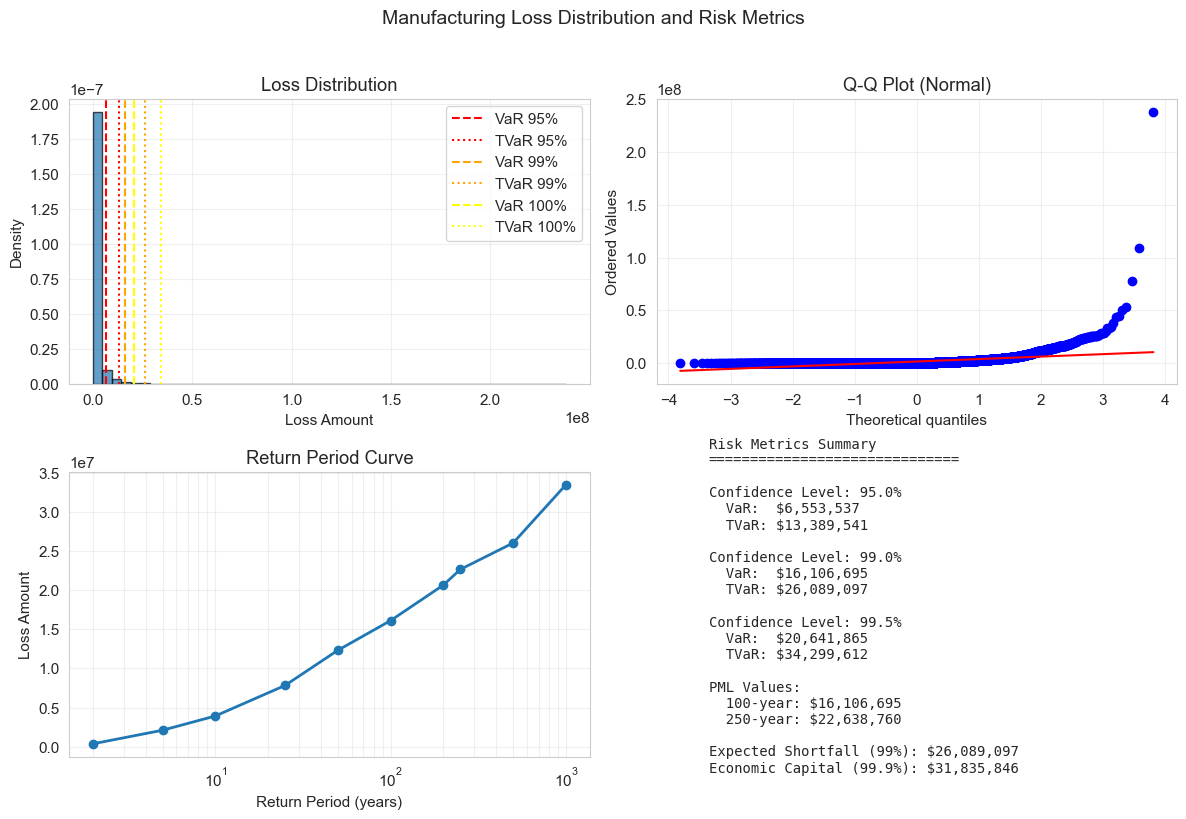

In [6]:
# Create comprehensive risk visualization
fig = metrics.plot_distribution(
    bins=50,
    show_metrics=True,
    confidence_levels=[0.95, 0.99, 0.995]
)
plt.suptitle('Manufacturing Loss Distribution and Risk Metrics', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Bootstrap Confidence Intervals

Calculate confidence intervals for risk metrics using bootstrap methods.

In [7]:
# Calculate VaR with bootstrap confidence intervals
print("VaR with 95% Bootstrap Confidence Intervals\n" + "="*50)
print(f"{'Confidence':<12} {'VaR':>15} {'CI Lower':>15} {'CI Upper':>15}")
print("-"*57)

for conf in [0.95, 0.99, 0.995]:
    result = metrics.var(conf, bootstrap_ci=True, n_bootstrap=1000)
    ci_lower, ci_upper = result.confidence_interval
    
    print(f"{conf:>10.1%}  ${result.value:>14,.0f}  ${ci_lower:>14,.0f}  ${ci_upper:>14,.0f}")

VaR with 95% Bootstrap Confidence Intervals
Confidence               VaR        CI Lower        CI Upper
---------------------------------------------------------
     95.0%  $     6,553,537  $     6,189,764  $     6,991,724
     99.0%  $    16,106,695  $    15,110,513  $    16,897,184
     99.5%  $    20,641,865  $    18,612,998  $    23,231,496


## 5. Coherence Properties Testing

Verify that TVaR satisfies the properties of a coherent risk measure.

In [8]:
# Test coherence properties
coherence_results = metrics.coherence_test()

print("Coherence Properties of TVaR\n" + "="*40)
for property_name, satisfied in coherence_results.items():
    status = "✓ Satisfied" if satisfied else "✗ Not satisfied"
    print(f"{property_name.replace('_', ' ').title()}: {status}")

print("\nNote: A coherent risk measure satisfies:")
print("  1. Monotonicity")
print("  2. Sub-additivity")
print("  3. Positive homogeneity")
print("  4. Translation invariance")

Coherence Properties of TVaR
Tvar Positive Homogeneity: ✓ Satisfied
Tvar Translation Invariance: ✓ Satisfied

Note: A coherent risk measure satisfies:
  1. Monotonicity
  2. Sub-additivity
  3. Positive homogeneity
  4. Translation invariance


## 6. Compare Different Loss Scenarios

Compare risk metrics across different operational scenarios.

In [9]:
# Generate different scenarios
scenarios = {}

# Base case
scenarios['Base Case'] = annual_losses

# High frequency scenario (more claims)
attritional_params_high = {
    'base_frequency': 8.0,
    'severity_mean': 50_000,
    'severity_cv': 0.8,
    'revenue_scaling_exponent': 0.3,
    'reference_revenue': 50_000_000
}

large_params_high = {
    'base_frequency': 0.8,
    'severity_mean': 2_000_000,
    'severity_cv': 1.2,
    'revenue_scaling_exponent': 0.2,
    'reference_revenue': 50_000_000
}

generator_high_freq = ManufacturingLossGenerator(
    attritional_params=attritional_params_high,
    large_params=large_params_high,
    seed=43
)

high_freq_losses = []
for _ in range(5000):
    events, stats = generator_high_freq.generate_losses(duration=1.0, revenue=annual_revenue)
    high_freq_losses.append(sum(e.amount for e in events))
scenarios['High Frequency'] = np.array(high_freq_losses)

# High severity scenario (larger claims)
attritional_params_sev = {
    'base_frequency': 5.0,
    'severity_mean': 75_000,
    'severity_cv': 0.8,
    'revenue_scaling_exponent': 0.3,
    'reference_revenue': 50_000_000
}

large_params_sev = {
    'base_frequency': 0.5,
    'severity_mean': 4_000_000,
    'severity_cv': 1.5,
    'revenue_scaling_exponent': 0.2,
    'reference_revenue': 50_000_000
}

generator_high_sev = ManufacturingLossGenerator(
    attritional_params=attritional_params_sev,
    large_params=large_params_sev,
    seed=44
)

high_sev_losses = []
for _ in range(5000):
    events, stats = generator_high_sev.generate_losses(duration=1.0, revenue=annual_revenue)
    high_sev_losses.append(sum(e.amount for e in events))
scenarios['High Severity'] = np.array(high_sev_losses)

# Compare scenarios
comparison_df = compare_risk_metrics(scenarios, confidence_levels=[0.95, 0.99, 0.995])
print("Risk Metrics Comparison Across Scenarios")
print("="*60)
display(comparison_df.round(0))

Risk Metrics Comparison Across Scenarios


,scenario,mean,median,std,skewness,kurtosis,min,max,count,var_95.0%,tvar_95.0%,var_99.0%,tvar_99.0%,var_99.5%,tvar_99.5%,pml_100yr,pml_250yr,max_drawdown,economic_capital
0,Base Case,1602519.0,380042.0,4158945.0,23.0,1113.0,0.0,238069047.0,10000,6553537.0,13389541.0,16106695.0,26089097.0,20641865.0,34299612.0,16106695.0,22638760.0,0.0,31835846.0
1,High Frequency,2039980.0,974290.0,2754044.0,4.0,33.0,33138.0,50180098.0,5000,7144809.0,10805430.0,12090569.0,17805726.0,16564412.0,21904156.0,12090569.0,17388844.0,0.0,23592320.0
2,High Severity,2356795.0,561690.0,5053773.0,7.0,98.0,0.0,114671829.0,5000,10515083.0,18692638.0,21522601.0,36683746.0,30792849.0,47257562.0,21522601.0,34007702.0,0.0,44550152.0


## 7. Return Period Analysis

Analyze the relationship between return periods and loss magnitudes.

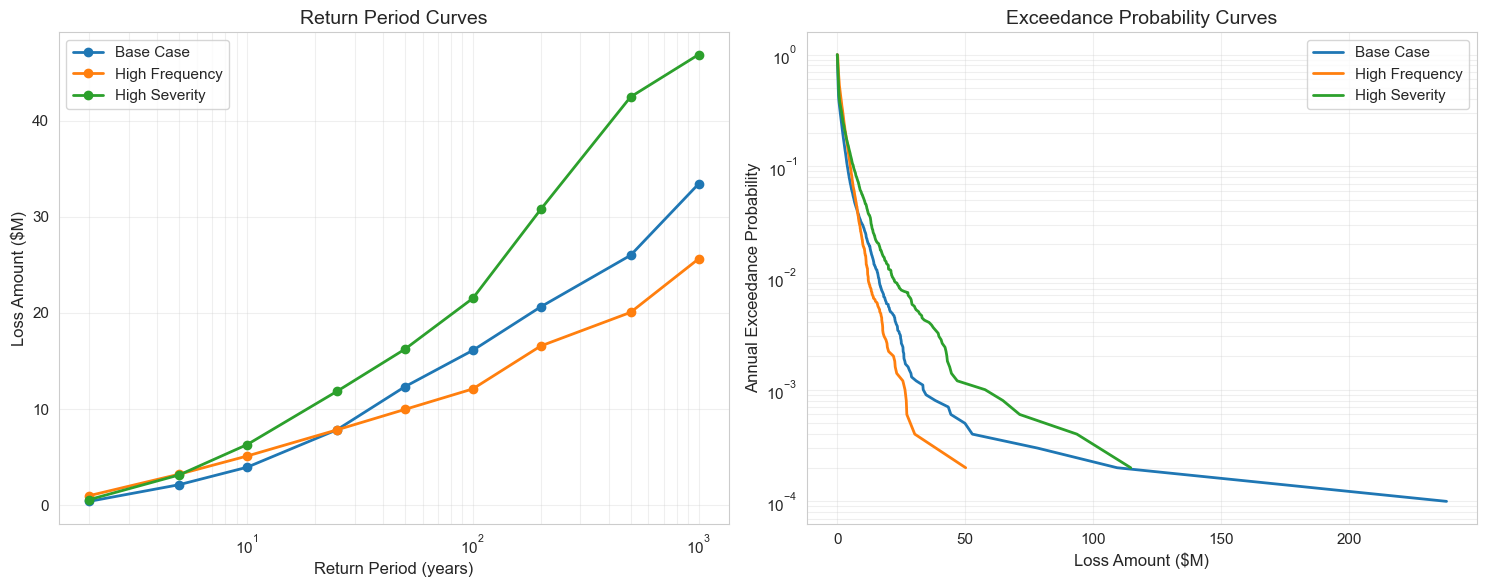

In [10]:
# Generate return period curves for all scenarios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Return period curves
return_periods = np.array([2, 5, 10, 25, 50, 100, 200, 500, 1000])

for scenario_name, losses in scenarios.items():
    scenario_metrics = RiskMetrics(losses)
    periods, loss_values = scenario_metrics.return_period_curve(return_periods)
    ax1.semilogx(periods, loss_values / 1e6, 'o-', label=scenario_name, linewidth=2, markersize=6)

ax1.set_xlabel('Return Period (years)', fontsize=12)
ax1.set_ylabel('Loss Amount ($M)', fontsize=12)
ax1.set_title('Return Period Curves', fontsize=14)
ax1.grid(True, alpha=0.3, which='both')
ax1.legend()

# Plot 2: Exceedance probability
for scenario_name, losses in scenarios.items():
    sorted_losses = np.sort(losses)[::-1]
    exceedance_prob = np.arange(1, len(sorted_losses) + 1) / len(sorted_losses)
    ax2.semilogy(sorted_losses / 1e6, exceedance_prob, '-', label=scenario_name, linewidth=2)

ax2.set_xlabel('Loss Amount ($M)', fontsize=12)
ax2.set_ylabel('Annual Exceedance Probability', fontsize=12)
ax2.set_title('Exceedance Probability Curves', fontsize=14)
ax2.grid(True, alpha=0.3, which='both')
ax2.legend()

plt.tight_layout()
plt.show()

## 8. Insurance Limit Selection Using Risk Metrics

Demonstrate how risk metrics inform insurance limit selection.

In [11]:
# Analyze insurance limit options
print("Insurance Limit Selection Analysis\n" + "="*50)

# Define potential insurance limits based on risk metrics
limit_options = {
    'Conservative': metrics.var(0.95),
    'Standard': metrics.var(0.99),
    'PML-100': metrics.pml(100),
    'PML-250': metrics.pml(250),
    'Aggressive': metrics.tvar(0.99),
}

# Calculate coverage statistics for each limit
print(f"{'Limit Option':<15} {'Limit Amount':>15} {'Coverage %':>12} {'Avg Uncovered':>15}")
print("-"*60)

for option_name, limit in limit_options.items():
    covered_pct = np.mean(annual_losses <= limit) * 100
    uncovered_losses = annual_losses[annual_losses > limit] - limit
    avg_uncovered = np.mean(uncovered_losses) if len(uncovered_losses) > 0 else 0
    
    print(f"{option_name:<15} ${limit:>14,.0f} {covered_pct:>11.1f}% ${avg_uncovered:>14,.0f}")

# Recommendation
print("\n" + "="*50)
print("Recommendation:")
print(f"  • For cost-conscious: Use VaR(95%) = ${limit_options['Conservative']:,.0f}")
print(f"  • For balanced approach: Use PML-100 = ${limit_options['PML-100']:,.0f}")
print(f"  • For comprehensive coverage: Use TVaR(99%) = ${limit_options['Aggressive']:,.0f}")

Insurance Limit Selection Analysis
Limit Option       Limit Amount   Coverage %   Avg Uncovered
------------------------------------------------------------
Conservative    $     6,553,537        95.0% $     6,836,004
Standard        $    16,106,695        99.0% $     9,982,401
PML-100         $    16,106,695        99.0% $     9,982,401
PML-250         $    22,638,760        99.6% $    14,737,231
Aggressive      $    26,089,097        99.8% $    26,893,631

Recommendation:
  • For cost-conscious: Use VaR(95%) = $6,553,537
  • For balanced approach: Use PML-100 = $16,106,695
  • For comprehensive coverage: Use TVaR(99%) = $26,089,097


## 9. Summary Statistics

Complete statistical summary of the loss distribution.

In [12]:
# Get comprehensive summary statistics
summary = metrics.summary_statistics()

print("Loss Distribution Summary Statistics\n" + "="*40)
for stat_name, value in summary.items():
    if stat_name == 'count':
        print(f"{stat_name.capitalize():<15}: {value:,.0f}")
    elif stat_name in ['skewness', 'kurtosis']:
        print(f"{stat_name.capitalize():<15}: {value:.3f}")
    else:
        print(f"{stat_name.capitalize():<15}: ${value:,.0f}")

# Interpretation
print("\n" + "="*40)
print("Interpretation:")
if summary['skewness'] > 1:
    print("  • Highly right-skewed distribution (heavy tail)")
elif summary['skewness'] > 0:
    print("  • Moderately right-skewed distribution")
else:
    print("  • Symmetric or left-skewed distribution")

if summary['kurtosis'] > 3:
    print("  • Leptokurtic (fat tails, higher tail risk)")
elif summary['kurtosis'] < 3:
    print("  • Platykurtic (thin tails, lower tail risk)")
else:
    print("  • Mesokurtic (normal-like tails)")

Loss Distribution Summary Statistics
Mean           : $1,602,519
Median         : $380,042
Std            : $4,158,945
Skewness       : 22.970
Kurtosis       : 1112.958
Min            : $0
Max            : $238,069,047
Count          : 10,000

Interpretation:
  • Highly right-skewed distribution (heavy tail)
  • Leptokurtic (fat tails, higher tail risk)


## 10. Risk-Adjusted Performance Metrics

Calculate risk-adjusted metrics for investment decision-making.

In [13]:
# Assume company generates returns that offset losses
# Convert losses to returns for risk-adjusted metrics
expected_revenue = 50_000_000
operating_margin = 0.08
expected_profit = expected_revenue * operating_margin

# Net returns after losses
net_returns = expected_profit - annual_losses

# Calculate risk-adjusted metrics
metrics_returns = RiskMetrics(-net_returns)  # Negative because we want returns, not losses
risk_adjusted = metrics_returns.risk_adjusted_metrics(risk_free_rate=0.02)

print("Risk-Adjusted Performance Metrics\n" + "="*40)
print(f"Mean Return: ${-risk_adjusted['mean_return']:,.0f}")
print(f"Volatility: ${risk_adjusted['volatility']:,.0f}")
print(f"Sharpe Ratio: {risk_adjusted['sharpe_ratio']:.3f}")
print(f"Sortino Ratio: {risk_adjusted['sortino_ratio']:.3f}")

print("\n" + "="*40)
print("Interpretation:")
if risk_adjusted['sharpe_ratio'] > 1:
    print("  • Excellent risk-adjusted returns")
elif risk_adjusted['sharpe_ratio'] > 0.5:
    print("  • Good risk-adjusted returns")
elif risk_adjusted['sharpe_ratio'] > 0:
    print("  • Positive but modest risk-adjusted returns")
else:
    print("  • Negative risk-adjusted returns")

Risk-Adjusted Performance Metrics
Mean Return: $-2,397,481
Volatility: $4,158,945
Sharpe Ratio: 0.576
Sortino Ratio: 0.236

Interpretation:
  • Good risk-adjusted returns


## Conclusions

This comprehensive risk metrics suite provides:

1. **VaR and TVaR** for regulatory compliance and risk limits
2. **PML** for catastrophe modeling and reinsurance decisions
3. **Expected Shortfall** for tail risk assessment
4. **Economic Capital** for capital allocation
5. **Return Period Curves** for insurance limit selection
6. **Bootstrap Confidence Intervals** for uncertainty quantification
7. **Coherence Testing** to verify risk measure properties
8. **Risk-Adjusted Metrics** for investment decisions

These metrics enable data-driven insurance optimization that transforms insurance from a cost center to a strategic growth enabler.